C:\Users\MouadKHAZNAOUI\AppData\Local\Temp\ipykernel_4384\1009456345.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  read_image = lambda x: np.expand_dims(imread(x)[::2, ::2], 0)


Total samples are 267
Image resolution is (1, 256, 256)
Epoch 1/10


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Training Loss: 779722.5833333334, Validation Loss: 237930.5703125


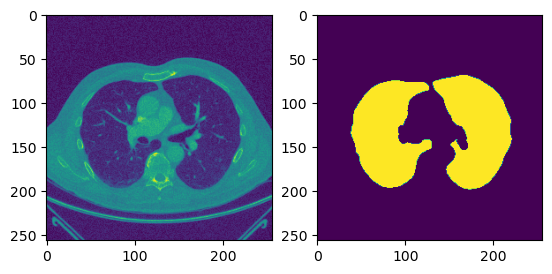

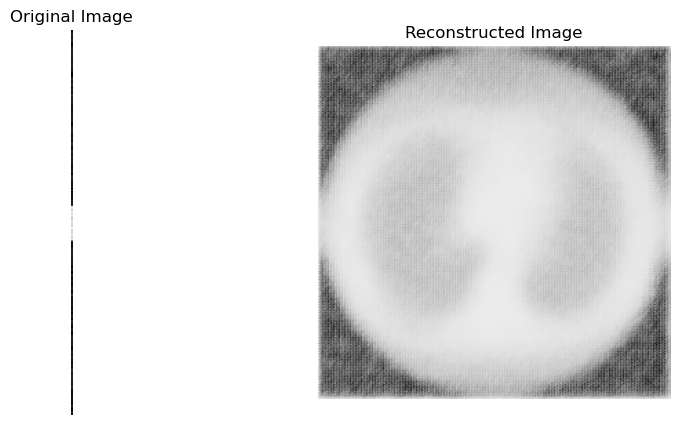

Epoch 2/10


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Training Loss: 214591.234375, Validation Loss: 160625.4453125


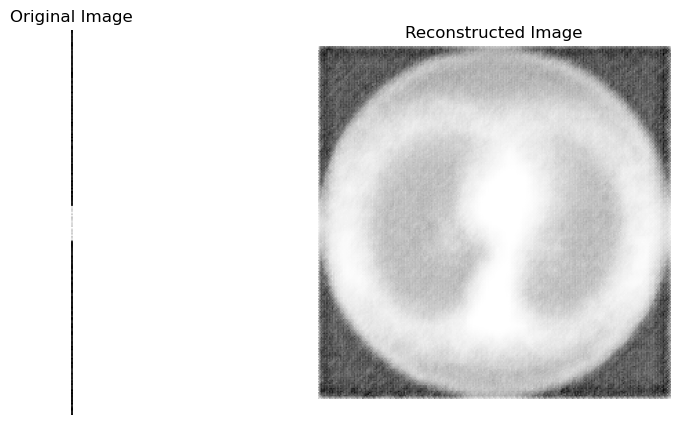

Epoch 3/10


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Training Loss: 146564.89270833333, Validation Loss: 126430.71875


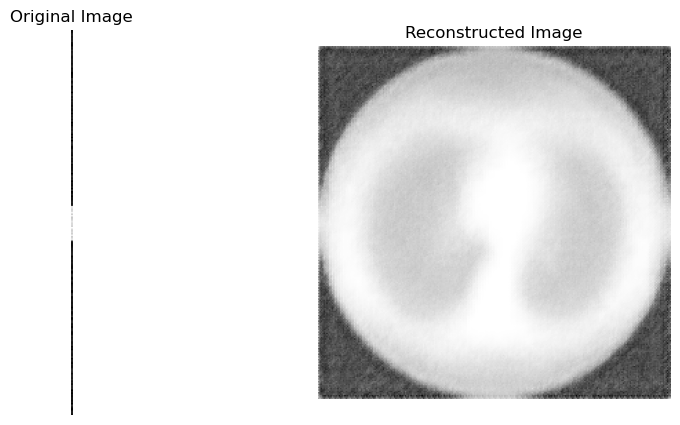

Epoch 4/10


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Training Loss: 126742.99010416666, Validation Loss: 117424.70703125


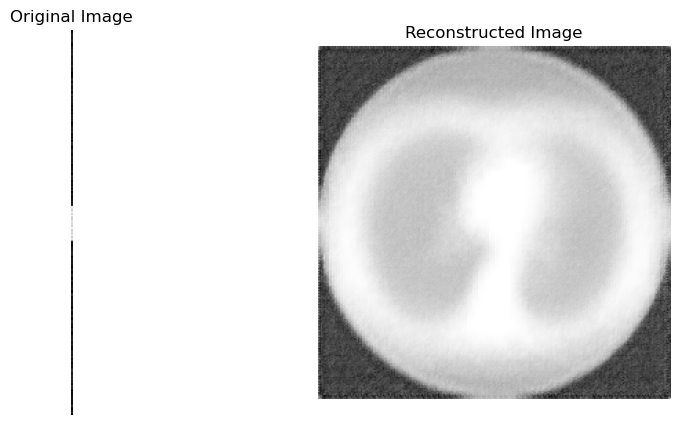

Epoch 5/10


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Training Loss: 119487.56145833334, Validation Loss: 110780.484375


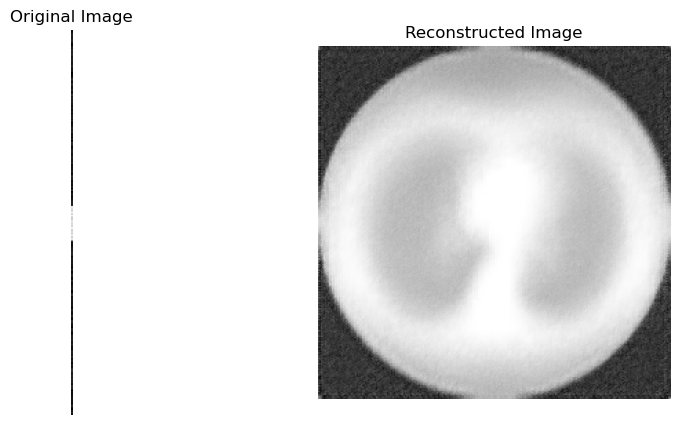

Epoch 6/10


100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Training Loss: 113846.06770833333, Validation Loss: 105923.99609375


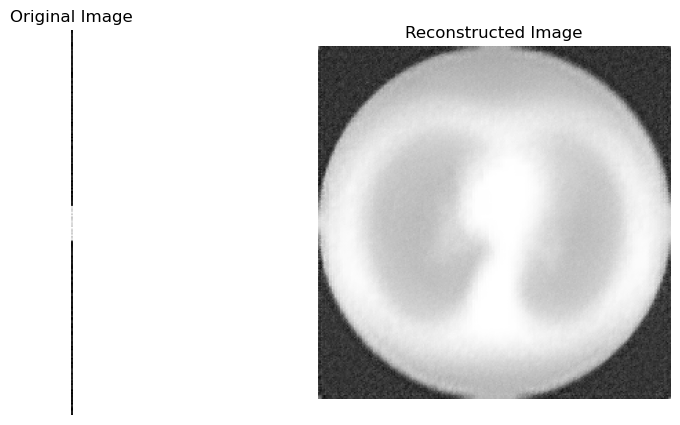

Epoch 7/10


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Training Loss: 105853.83020833334, Validation Loss: 95067.06640625


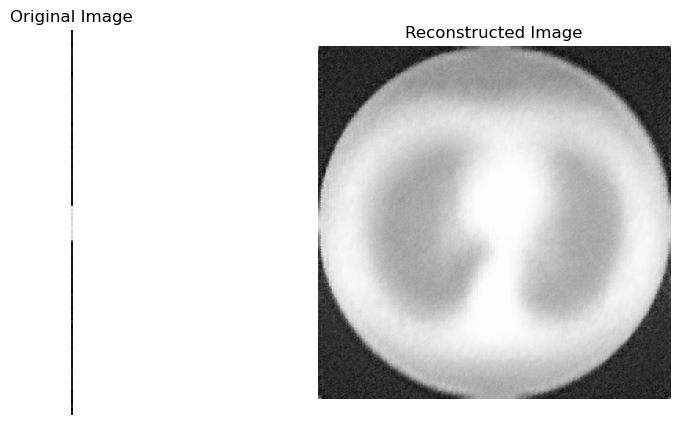

Epoch 8/10


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Training Loss: 98138.384375, Validation Loss: 96003.94921875


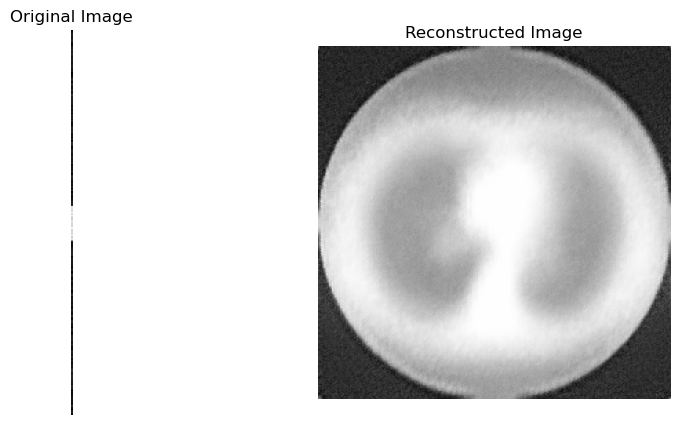

Epoch 9/10


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Training Loss: 94634.18802083333, Validation Loss: 90487.7578125


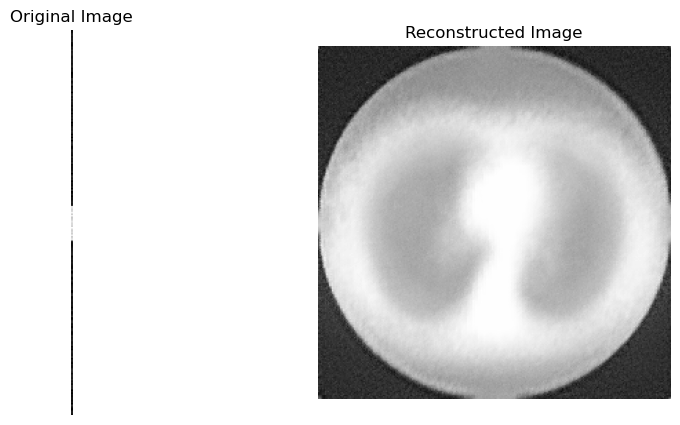

Epoch 10/10


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Training Loss: 91285.73125, Validation Loss: 88830.18359375


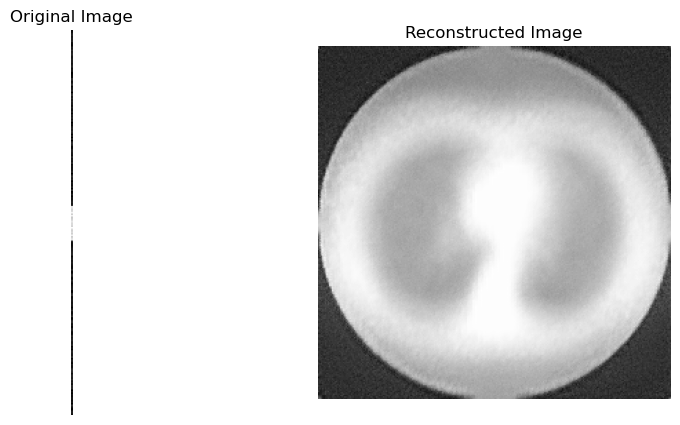

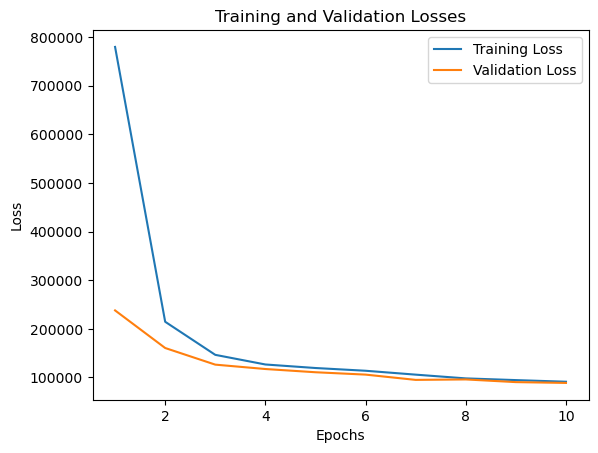

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from imageio import imread
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm

# Définir le format des données d'image
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

# Fonction pour lire une image
read_image = lambda x: np.expand_dims(imread(x)[::2, ::2], 0)

# Chemin de base pour les images et les masques
BASE_IMAGE_PATH = os.path.join('C:\\Users\\MouadKHAZNAOUI\\Downloads', '2d_images')
all_images = glob(os.path.join(BASE_IMAGE_PATH, '*.tif'))
all_masks = ['_masks'.join(c_file.split('_images')) for c_file in all_images]

# Lire une image et son masque pour obtenir les dimensions
t_img = read_image(all_images[0])
t_msk = read_image(all_masks[0])

# Afficher une paire d'image et de masque
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(t_img[0])
ax2.imshow(t_msk[0])

# Afficher des informations sur les données
print('Total samples are', len(all_images))
print('Image resolution is', t_img.shape)

# Charger toutes les images et masques dans des tableaux NumPy
img = np.stack([read_image(i) for i in all_images], 0)
msk = np.stack([read_image(i) for i in all_masks], 0) / 255.0

# Transposer les dimensions pour correspondre à ce que le modèle attend
img = np.transpose(img, (0, 2, 3, 1))
msk = np.transpose(msk, (0, 2, 3, 1))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(img, msk, test_size=0.1)

class Encoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.Flatten(),
            nn.Linear(4*out_channels*64*64, latent_dim),
            act_fn
        )

    def forward(self, x):
        x = x.view(-1, 1, 256, 256)
        output = self.net(x)
        return output

class Decoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()

        self.out_channels = out_channels

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4*out_channels*64*64, dtype=torch.float32),
            act_fn
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, stride=2, output_padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, stride=2, output_padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1, dtype=torch.float32),  # Ajout de dtype=torch.float32
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1, dtype=torch.float32)  # Ajout de dtype=torch.float32
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 4*self.out_channels, 64, 64)
        output = self.conv(output)
        return output


# Définir le modèle de l'autoencodeur
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Définir la classe ConvolutionalAutoencoder
class ConvolutionalAutoencoder():
    def __init__(self, autoencoder):
        self.network = autoencoder
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)
        self.train_losses = []
        self.val_losses = []

    def train(self, loss_function, epochs, batch_size, training_set, validation_set, test_set):
        # Initialiser les poids du réseau
        self.network.apply(self.init_weights)

        # Créer les dataloaders
        train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(validation_set, batch_size=batch_size)
        test_loader = DataLoader(test_set, batch_size=1)

        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}')
            self.network.train()
            epoch_train_loss = []

            # Entraînement
            for images in tqdm(train_loader):
                self.optimizer.zero_grad()
                # Mettre à jour la taille des images
                images = images.view(-1, 1, 256, 256)
                reconstructed = self.network(images)
                loss = loss_function(reconstructed, images)
                loss.backward()
                self.optimizer.step()
                epoch_train_loss.append(loss.item())

            self.train_losses.append(sum(epoch_train_loss) / len(epoch_train_loss))

            # Validation
            epoch_val_loss = []
            self.network.eval()
            with torch.no_grad():
                for val_images in tqdm(val_loader):
                    # Mettre à jour la taille des images
                    val_images = val_images.view(-1, 1, 256, 256)
                    reconstructed = self.network(val_images)
                    val_loss = loss_function(reconstructed, val_images)
                    epoch_val_loss.append(val_loss.item())

            self.val_losses.append(sum(epoch_val_loss) / len(epoch_val_loss))

            print(f'Training Loss: {self.train_losses[-1]}, Validation Loss: {self.val_losses[-1]}')

            # Visualisation
            self.visualize(test_loader)

        # Plotting training and validation losses
        plt.plot(range(1, epochs+1), self.train_losses, label='Training Loss')
        plt.plot(range(1, epochs+1), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

    def visualize(self, test_loader):
        self.network.eval()
        with torch.no_grad():
            test_images = next(iter(test_loader))
            reconstructed = self.network(test_images)
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            axes[0].imshow(test_images[0][0], cmap='gray')
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            axes[1].imshow(reconstructed[0][0], cmap='gray')
            axes[1].set_title('Reconstructed Image')
            axes[1].axis('off')
            plt.show()

    def init_weights(self, module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.01)

# Convertir les données en torch.float32 avant de les passer au modèle
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

# Entraînement du modèle
model = ConvolutionalAutoencoder(Autoencoder(Encoder(), Decoder()))
model.train(nn.MSELoss(), epochs=10, batch_size=16, training_set=X_train_tensor, validation_set=X_test_tensor, test_set=X_test_tensor)

In [7]:
# Après l'entraînement du modèle

from sklearn.decomposition import PCA
import pandas as pd
import os

# Obtenir les caractéristiques encodées des images d'entraînement
encoded_images_train = model.network.encoder(X_train_tensor).detach().numpy()

# Obtenir les caractéristiques encodées des images de test
encoded_images_test = model.network.encoder(X_test_tensor).detach().numpy()

# Réduire la taille des ensembles d'entraînement et de test en échantillonnant aléatoirement un sous-ensemble des données
sample_size = 10  # Choisissez la taille de l'échantillon à utiliser
X_train_sample = X_train[:sample_size]
X_test_sample = X_test[:sample_size]

# Reconstruire les images à partir des caractéristiques pour calculer l'erreur de reconstruction
reconstructed_train = model.network.decoder(torch.from_numpy(encoded_images_train[:sample_size]).float())
reconstructed_test = model.network.decoder(torch.from_numpy(encoded_images_test[:sample_size]).float())

# Calculer l'erreur de reconstruction pour chaque image dans l'échantillon
reconstruction_errors_train = np.mean(np.abs(X_train_sample - reconstructed_train.detach().numpy()), axis=(1, 2, 3))
reconstruction_errors_test = np.mean(np.abs(X_test_sample - reconstructed_test.detach().numpy()), axis=(1, 2, 3))


encoded_images_train_sample = encoded_images_train[:sample_size]
encoded_images_test_sample = encoded_images_test[:sample_size]


# Aplatir les images encodées pour PCA
flat_train = encoded_images_train.reshape(len(encoded_images_train_sample), -1)
flat_test = encoded_images_test.reshape(len(encoded_images_test_sample), -1)

# Initialiser PCA avec 6 composants
pca = PCA(n_components=6)

# Appliquer PCA sur l'ensemble d'entraînement
pca_train = pca.fit_transform(flat_train)

# Créer un DataFrame pandas avec les caractéristiques
columns = ["Feature" + str(i+1) for i in range(pca_train.shape[1])]
df_train_pca = pd.DataFrame(pca_train, columns=columns)

# Ajouter les erreurs de reconstruction en tant que nouvelle colonne dans le DataFrame
df_train_pca['ReconstructionError'] = reconstruction_errors_train

# Enregistrer le DataFrame mis à jour dans un fichier CSV
df_train_pca.to_csv("pca_train_features_with_error_2N.csv", index=False)

C:\Users\MouadKHAZNAOUI\AppData\Local\Temp\ipykernel_4384\64774149.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  read_image = lambda x: np.expand_dims(imread(x)[::2, ::2], 0)


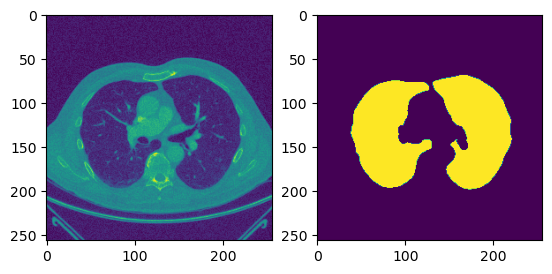

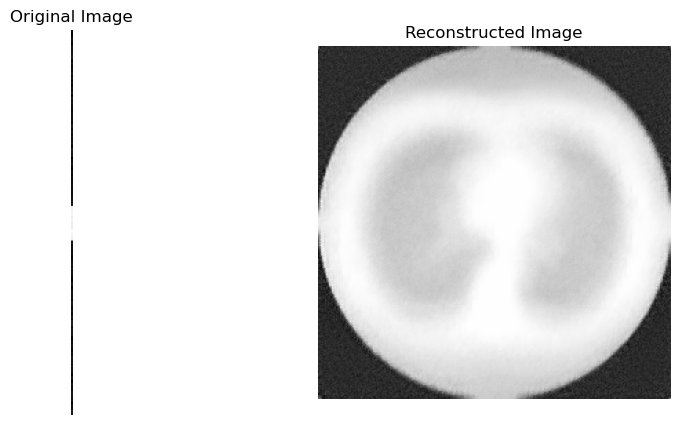

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from imageio import imread
import torch
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm

# Définir le format des données d'image
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

# Fonction pour lire une image
read_image = lambda x: np.expand_dims(imread(x)[::2, ::2], 0)

# Chemin de base pour les images et les masques
BASE_IMAGE_PATH = os.path.join('C:\\Users\\MouadKHAZNAOUI\\Downloads', '2d_images')
all_images = glob(os.path.join(BASE_IMAGE_PATH, '*.tif'))
all_masks = ['_masks'.join(c_file.split('_images')) for c_file in all_images]

# Lire une image et son masque pour obtenir les dimensions
t_img = read_image(all_images[0])
t_msk = read_image(all_masks[0])

# Afficher une paire d'image et de masque
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(t_img[0])
ax2.imshow(t_msk[0])

# Charger toutes les images et masques dans des tableaux NumPy
img = np.stack([read_image(i) for i in all_images], 0)
msk = np.stack([read_image(i) for i in all_masks], 0) / 255.0

# Transposer les dimensions pour correspondre à ce que le modèle attend
img = np.transpose(img, (0, 2, 3, 1))
msk = np.transpose(msk, (0, 2, 3, 1))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(img, msk, test_size=0.1)

# Convertir les données en torch.float32 avant de les passer au modèle
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

# Fonction pour afficher des images originales et reconstruites
def visualize_original_reconstructed_images(model, test_loader):
    model.network.eval()
    with torch.no_grad():
        test_images = next(iter(test_loader))
        reconstructed = model.network(test_images)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        axes[0].imshow(test_images[0][0], cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[1].imshow(reconstructed[0][0], cmap='gray')
        axes[1].set_title('Reconstructed Image')
        axes[1].axis('off')
        plt.show()

# Créer le DataLoader pour les données de test
test_loader = DataLoader(X_test_tensor, batch_size=1)

# Appeler la fonction pour afficher des images originales et reconstruites
visualize_original_reconstructed_images(model, test_loader)

Quelques images de l'ensemble d'entraînement:


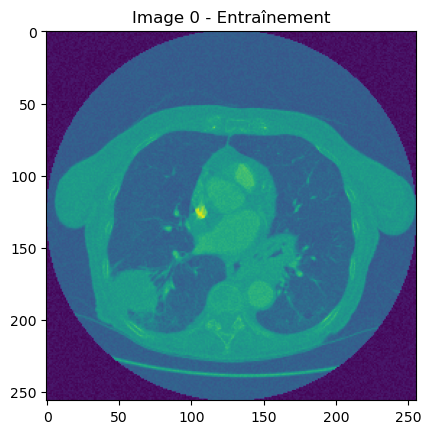

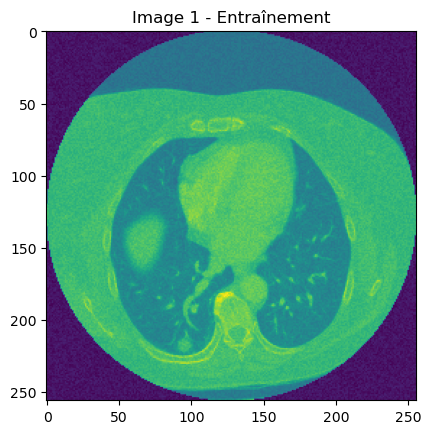

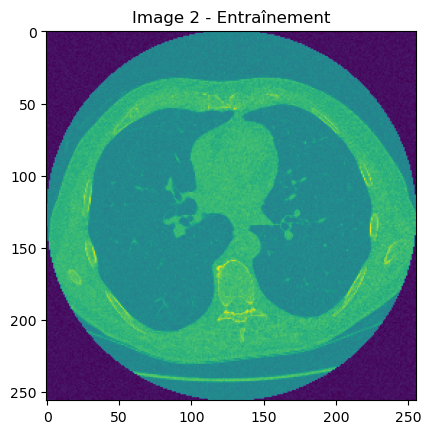

Quelques images de l'ensemble de test:


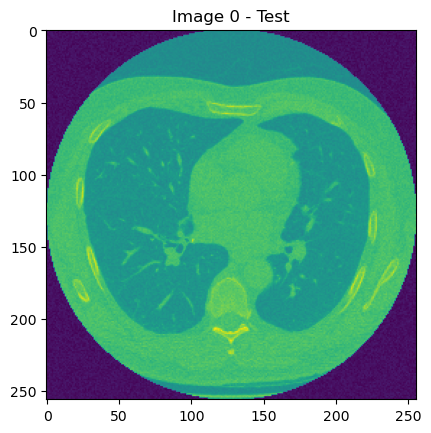

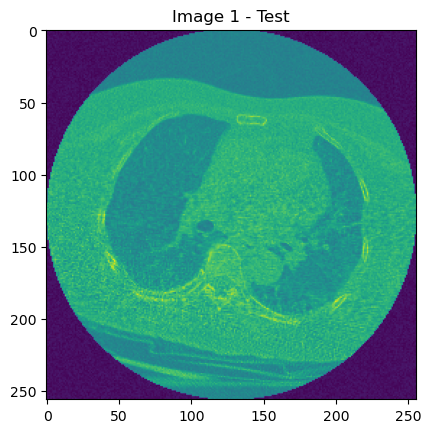

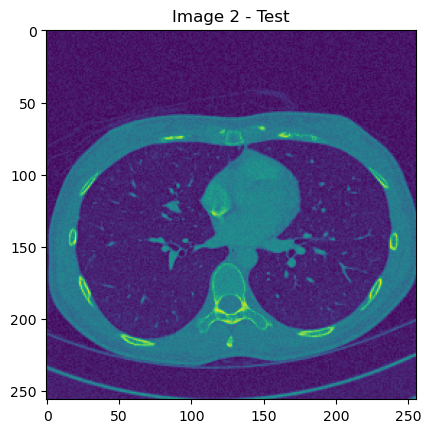

In [5]:
# Afficher quelques images de l'ensemble d'entraînement
print("Quelques images de l'ensemble d'entraînement:")
indices_train = [0, 1, 2]  # Indices des images à afficher
for i in indices_train:
    plt.imshow(X_train_tensor[i].numpy())
    plt.title('Image ' + str(i) + ' - Entraînement')
    plt.show()

# Afficher quelques images de l'ensemble de test
print("Quelques images de l'ensemble de test:")
indices_test = [0, 1, 2]  # Indices des images à afficher
for i in indices_test:
    plt.imshow(X_test_tensor[i].numpy())
    plt.title('Image ' + str(i) + ' - Test')
    plt.show()

Epoch 1/10


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Training Loss: 713042.1333333333, Validation Loss: 300220.171875


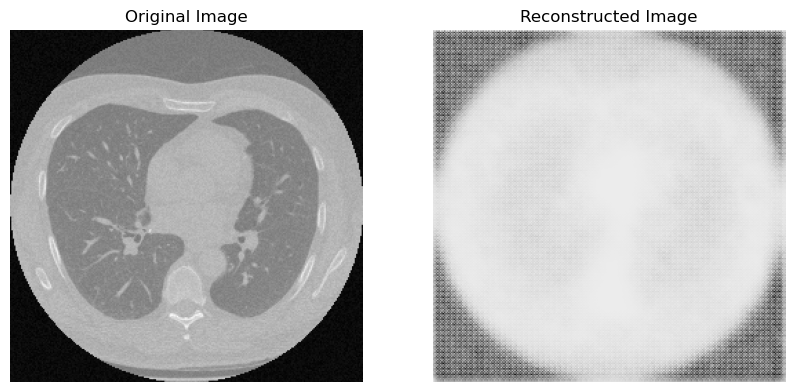

Epoch 2/10


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Training Loss: 215968.75416666668, Validation Loss: 141022.078125


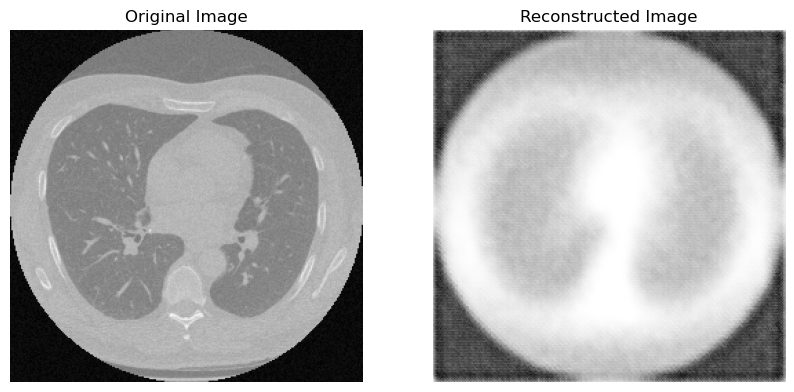

Epoch 3/10


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Training Loss: 150118.946875, Validation Loss: 127158.48046875


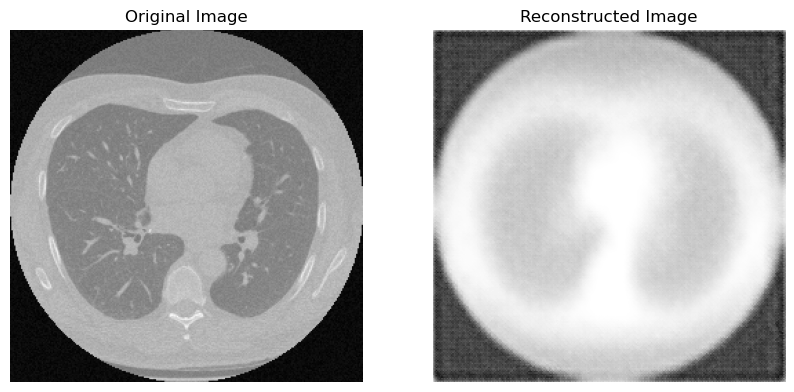

Epoch 4/10


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Training Loss: 120897.18072916666, Validation Loss: 113293.7890625


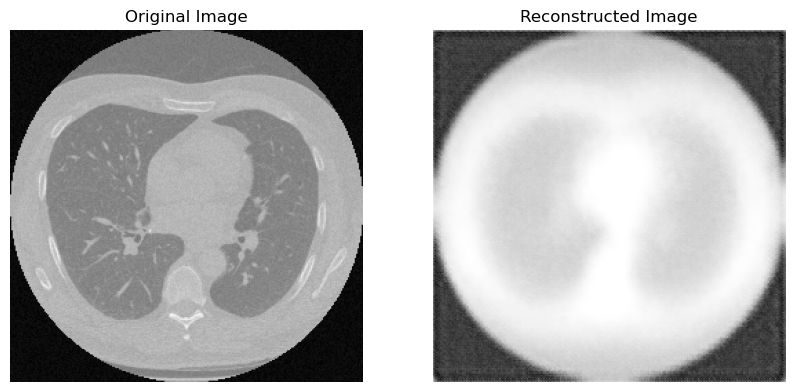

Epoch 5/10


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Training Loss: 105999.5359375, Validation Loss: 100727.9375


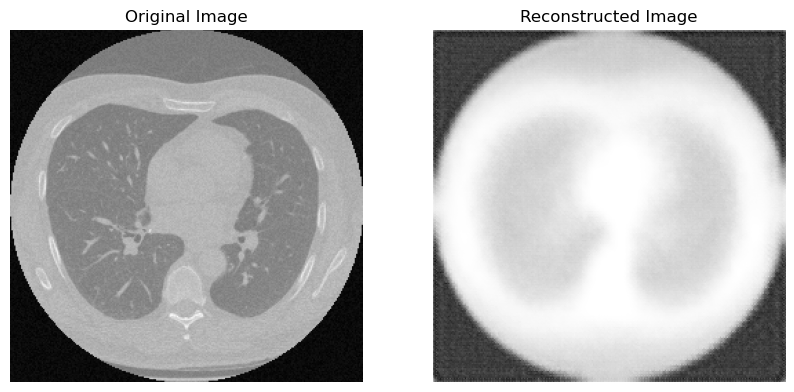

Epoch 6/10


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Training Loss: 99066.38541666667, Validation Loss: 94993.0859375


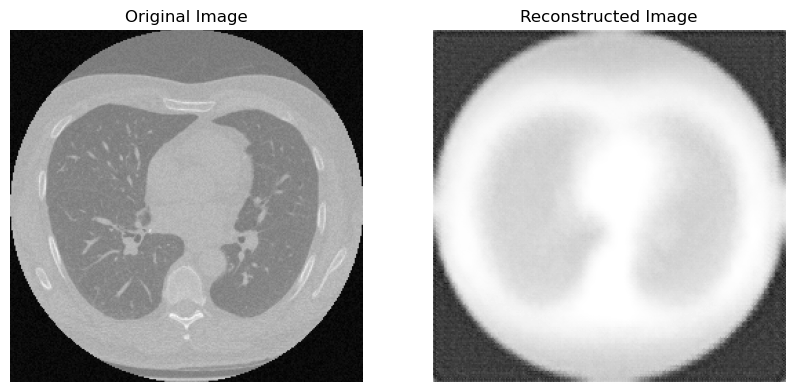

Epoch 7/10


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Training Loss: 95262.61927083334, Validation Loss: 92614.84375


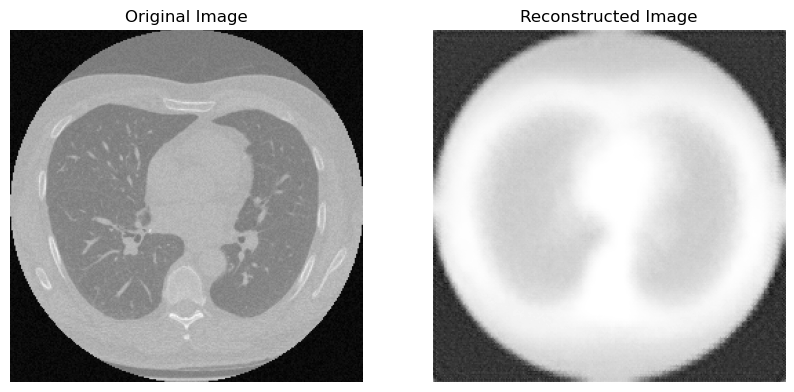

Epoch 8/10


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Training Loss: 92501.759375, Validation Loss: 90709.83203125


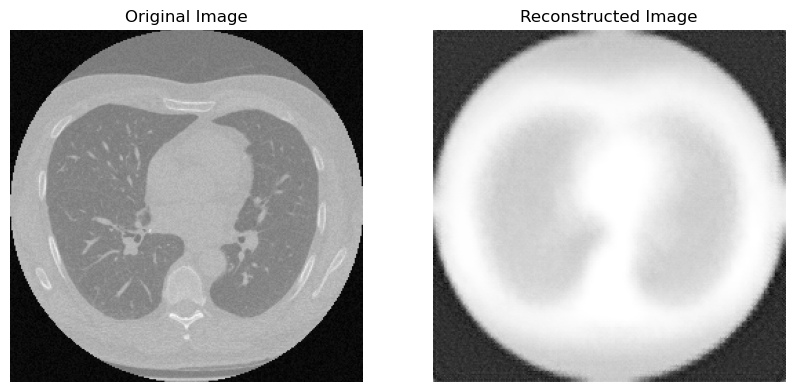

Epoch 9/10


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Training Loss: 91174.26041666667, Validation Loss: 89129.24609375


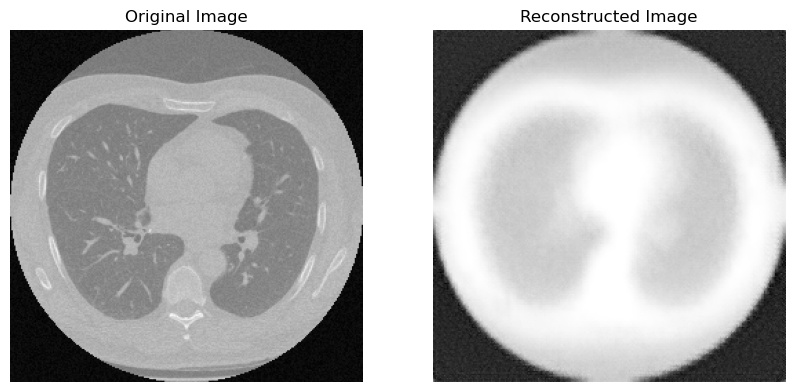

Epoch 10/10


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Training Loss: 89050.89739583334, Validation Loss: 87233.66796875


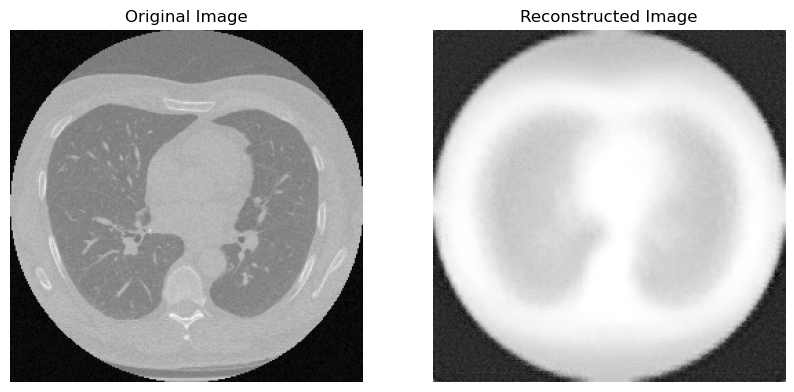

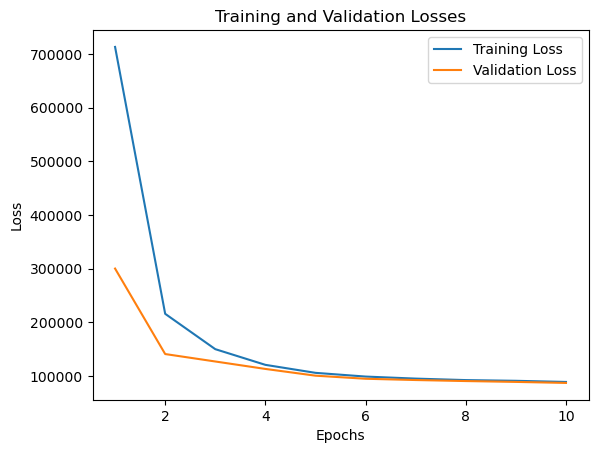

In [6]:
# Convertir les données en torch.float32 avant de les passer au modèle
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

# Prétraiter les données pour qu'elles aient les dimensions attendues par le modèle
X_train_tensor = X_train_tensor.view(-1, 1, 256, 256)
X_test_tensor = X_test_tensor.view(-1, 1, 256, 256)

# Entraînement du modèle
model = ConvolutionalAutoencoder(Autoencoder(Encoder(), Decoder()))
model.train(nn.MSELoss(), epochs=10, batch_size=16, training_set=X_train_tensor, validation_set=X_test_tensor, test_set=X_test_tensor)

In [34]:
from sklearn.decomposition import PCA
import pandas as pd
import os

# Concaténer les ensembles d'entraînement et de test en un seul ensemble de données
X_combined = np.concatenate((X_train, X_test), axis=0)

print(X_combined.shape)

# Mélanger les données
np.random.shuffle(X_combined)

# Convertir les données en torch.float32
X_combined_tensor = torch.from_numpy(X_combined).float()

# Obtenir les caractéristiques encodées des images combinées
encoded_images_combined = model.network.encoder(X_combined_tensor).detach().numpy()

# Réduire la taille de l'ensemble combiné en échantillonnant aléatoirement un sous-ensemble des données
sample_size = 12  # Choisissez la taille de l'échantillon à utiliser
X_combined_sample = X_combined[:sample_size]

# Reconstruire les images à partir des caractéristiques pour calculer l'erreur de reconstruction
reconstructed_combined = model.network.decoder(torch.from_numpy(encoded_images_combined[:sample_size]).float())

# Calculer l'erreur de reconstruction pour chaque image dans l'échantillon
reconstruction_errors_combined = np.mean(np.abs(X_combined_sample - reconstructed_combined.detach().numpy()), axis=(1, 2, 3))

# Aplatir les images encodées pour PCA
flat_combined = encoded_images_combined.reshape(len(X_combined_sample), -1)

# Initialiser PCA avec 6 composants
pca = PCA(n_components=6)

# Appliquer PCA sur l'ensemble combiné
pca_combined = pca.fit_transform(flat_combined)

# Créer un DataFrame pandas avec les caractéristiques
columns = ["Feature" + str(i+1) for i in range(pca_combined.shape[1])]
df_combined_pca = pd.DataFrame(pca_combined, columns=columns)

# Ajouter les erreurs de reconstruction en tant que nouvelle colonne dans le DataFrame
df_combined_pca['ReconstructionError'] = reconstruction_errors_combined

(267, 256, 256, 1)


In [13]:
import os

# Extraire les noms de fichiers des chemins d'images combinés
image_file_names_combined = [os.path.basename(file_path) for file_path in all_images]

# Créer un DataFrame pandas avec les caractéristiques combinées
df_combined_pca = pd.DataFrame(pca_combined, columns=columns)

# Ajouter les noms de fichiers d'images comme première colonne dans le DataFrame combiné
df_combined_pca.insert(0, 'ImageFileName', image_file_names_combined)

# Enregistrer le DataFrame mis à jour dans un fichier CSV
df_combined_pca.to_csv("pca_combined_features_with_error_10.csv", index=False)

ValueError: Length of values (267) does not match length of index (10)

In [49]:
from sklearn.decomposition import PCA
import pandas as pd
import os

# Concaténer les ensembles d'entraînement et de test en un seul ensemble de données
X_combined = np.concatenate((X_train, X_test), axis=0)

# Extraire les identifiants des images à partir des chemins de fichiers
train_ids = [os.path.basename(file_path) for file_path in all_images[:len(X_train)]]
test_ids = [os.path.basename(file_path) for file_path in all_images[len(X_train):]]

# Concaténer les identifiants des images d'entraînement et de test
ids_combined = np.concatenate((train_ids, test_ids), axis=0)

# Créer un DataFrame pour stocker les données combinées avec les IDs
df_combined = pd.DataFrame(X_combined.reshape(len(X_combined), -1))

# Ajouter une colonne pour les IDs dans le DataFrame combiné
df_combined['ImageID'] = ids_combined

# Mélanger les données
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

# Convertir les données en torch.float32
X_combined_tensor = torch.from_numpy(df_combined.iloc[:, :-1].values).float()

In [50]:
sample_size = 12 # Choisissez la taille de l'échantillon à utiliser

# Réduire la taille de l'ensemble combiné en échantillonnant aléatoirement un sous-ensemble des données
X_combined_sample = df_combined.iloc[:sample_size, :-1].values

# Aplatir les images encodées pour PCA
flat_combined = encoded_images_combined.reshape(sample_size, -1)

# Initialiser PCA avec 6 composants
pca = PCA(n_components=6)

# Appliquer PCA sur l'ensemble combiné
pca_combined = pca.fit_transform(flat_combined)

# Créer un DataFrame pandas avec les caractéristiques PCA
columns = ["Feature" + str(i+1) for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_combined, columns=columns)

# Ajouter les IDs d'image en tant que première colonne dans le DataFrame PCA
df_pca.insert(0, 'ImageID', df_combined['ImageID'])

# Obtenir les caractéristiques encodées des images combinées
encoded_images_combined = model.network.encoder(X_combined_tensor).detach().numpy()

# Reconstruire toutes les images à partir des caractéristiques pour calculer l'erreur de reconstruction
reconstructed_combined = model.network.decoder(torch.from_numpy(encoded_images_combined[:sample_size]).float())

# Aplatir les données reconstruites
reconstructed_flat = reconstructed_combined.view(reconstructed_combined.size(0), -1)

# Calculer l'erreur de reconstruction pour chaque image dans l'échantillon
reconstruction_errors_combined = np.mean(np.abs(X_combined_sample - reconstructed_flat.detach().numpy()), axis=1)

# Ajouter les erreurs de reconstruction en tant que nouvelle colonne dans le DataFrame PCA
df_pca['ReconstructionError'] = reconstruction_errors_combined

# Enregistrer le DataFrame mis à jour dans un fichier CSV
df_pca.to_csv("pca_all_combined_features_with_error.csv", index=False)

In [51]:
print("Shape of X_combined_sample:", X_combined_sample.shape)
print("Shape of reconstructed_combined:", reconstructed_combined.shape)

Shape of X_combined_sample: (12, 65536)
Shape of reconstructed_combined: torch.Size([12, 1, 256, 256])


In [67]:
from sklearn.decomposition import PCA
import pandas as pd
import os

# Concaténer les ensembles d'entraînement et de test en un seul ensemble de données
X_combined = np.concatenate((X_train, X_test), axis=0)

# Extraire les identifiants des images à partir des chemins de fichiers
train_ids = [os.path.basename(file_path) for file_path in all_images[:len(X_train)]]
test_ids = [os.path.basename(file_path) for file_path in all_images[len(X_train):]]

# Concaténer les identifiants des images d'entraînement et de test
ids_combined = np.concatenate((train_ids, test_ids), axis=0)

# Créer un DataFrame pour stocker les données combinées avec les IDs
df_combined = pd.DataFrame(X_combined.reshape(len(X_combined), -1))

# Ajouter une colonne pour les IDs dans le DataFrame combiné
df_combined['ImageID'] = ids_combined

# Mélanger les données
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

# Convertir les données en torch.float32
X_combined_tensor = torch.from_numpy(df_combined.iloc[:, :-1].values).float()

sample_size = 267 # Choisissez la taille de l'échantillon à utiliser

# Réduire la taille de l'ensemble combiné en échantillonnant aléatoirement un sous-ensemble des données
X_combined_sample = df_combined.iloc[:sample_size, :-1].values

# Aplatir les images encodées pour PCA
flat_combined = encoded_images_combined.reshape(sample_size, -1)

# Initialiser PCA avec 6 composants
pca = PCA(n_components=6)

# Appliquer PCA sur l'ensemble combiné
pca_combined = pca.fit_transform(flat_combined)

# Créer un DataFrame pandas avec les caractéristiques PCA
columns = ["Feature" + str(i+1) for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_combined, columns=columns)

# Ajouter les IDs d'image en tant que première colonne dans le DataFrame PCA
df_pca.insert(0, 'ImageID', df_combined['ImageID'])

# Obtenir les caractéristiques encodées des images combinées
encoded_images_combined = model.network.encoder(X_combined_tensor).detach().numpy()

# Reconstruire toutes les images à partir des caractéristiques pour calculer l'erreur de reconstruction
reconstructed_combined = model.network.decoder(torch.from_numpy(encoded_images_combined[:sample_size]).float())

# Aplatir les données reconstruites
reconstructed_flat = reconstructed_combined.view(reconstructed_combined.size(0), -1)

# Calculer l'erreur de reconstruction pour chaque image dans l'échantillon
reconstruction_errors_combined = np.mean(np.abs(X_combined_sample - reconstructed_flat.detach().numpy()), axis=1)

# Ajouter les erreurs de reconstruction en tant que nouvelle colonne dans le DataFrame PCA
df_pca['ReconstructionError'] = reconstruction_errors_combined

# Enregistrer le DataFrame mis à jour dans un fichier CSV
df_pca.to_csv("pca_all_features_stats.csv", index=False)